$r_{n} = log(\frac{S_{n}}{S_{n-1}})$

$historical\ volatility: \hat{\sigma} = \sqrt{(\frac{1}{N-1})\sum_{n=1}^{N}(r_{n}-\hat{\mu})^{2}}$ 

$instantaneous\ volatility: dS_{t} = rS_{t}dt+\sigma S_{t}dZ_{t}$

$implied\ volatility: C_{0} = C^{BSM}(S_{0}, K, T, r, \sigma^{imp})$

$realized\ volatility: RV_{t} = \sqrt{\sum_{i=1}^{N}r_{t}^{2}}$

Converting geometric brownian motion of BSM to discrete version:

$S_{t} = S_{t-\Delta t}e^{(r-(1/2)\sigma^{2})\Delta t+\sigma\sqrt{\Delta t}z_{t}}$

t = ${\Delta t, 2\Delta t, ... T}$

$z_{t}$ = standard normally distributed random variables

In [184]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as scs

sns.set_style('darkgrid')
%matplotlib inline

In [117]:
def generate_asset_price(S, r, sigma, dt, rand):
    return S * np.exp((r - sigma ** 2 / 2) * dt \
                + sigma * rand * math.sqrt(dt))

In [169]:
def simulate_gbm(S0, T, r, sigma, date_range, step_mult=252):
    '''
    Params
    -------------
    S0 = initial stock price
    T = # of years (can be fractional)
    r = r_f
    sigma = instantaneous vol
    step_mult = time-step mult for # of years (assuming daily calculations)
    '''
    np.random.seed(0)
    dt = 1.0 / step_mult
    df = np.exp(-r * dt) # discount factor
    
    M = len(date_range)
    I = 1  # index level paths
    
    print(M)
    
    rand_arr = np.random.standard_normal((M, I))
    
    S = np.zeros(M)
    S[0] = S0
    
    for t in range(1, M):
        S[t] = generate_asset_price(S[t-1], r, sigma, dt, rand_arr[t])
    
    gbm = pd.DataFrame(S, columns=['prices'])
    gbm['returns'] = np.log(gbm['prices'].pct_change(1) + 1)
    
    # realized volatility
    gbm['real_var'] = step_mult * np.cumsum(gbm['returns'] ** 2) / np.arange(len(gbm))
    gbm['real_vol'] = np.sqrt(gbm['real_var'])
    
    gbm.index = date_range
    gbm.dropna(inplace=True)
    
    return gbm

In [188]:
def print_statistics(data):
    print ("RETURN SAMPLE STATISTICS")
    print ("---------------------------------------------")
    print ("Mean of Daily  Log Returns %9.6f" % np.mean(data['returns']))
    print ("Std  of Daily  Log Returns %9.6f" % np.std(data['returns']))
    print ("Mean of Annua. Log Returns %9.6f" % (np.mean(data['returns']) * 252))
    print ("Std  of Annua. Log Returns %9.6f" % \
                (np.std(data['returns']) * math.sqrt(252)))
    print ("---------------------------------------------")
    print ("Skew of Sample Log Returns %9.6f" % scs.skew(data['returns']))
    print ("Skew Normal Test p-value   %9.6f" % scs.skewtest(data['returns'])[1])
    print ("---------------------------------------------")
    print ("Kurt of Sample Log Returns %9.6f" % scs.kurtosis(data['returns']))
    print ("Kurt Normal Test p-value   %9.6f" % \
                scs.kurtosistest(data['returns'])[1])
    print ("---------------------------------------------")
    print ("Normal Test p-value        %9.6f" % \
                scs.normaltest(data['returns'])[1])
    print ("---------------------------------------------")
    print ("Realized Volatility        %9.6f" % data['real_vol'].iloc[-1])
    print ("Realized Variance          %9.6f" % data['real_var'].iloc[-1])

In [189]:
S0 = 100.0  # initial index level
T = 10.0  # time horizon
r = 0.05  # risk-less short rate
sigma = 0.2  # instantaneous volatility
date_range = pd.date_range('2006-01-01', '2016-01-01')

df = simulate_gbm(S0, T, r, sigma, date_range)
df.head()

3653


,prices,returns,real_var,real_vol
2006-01-02,100.517389,0.005161,0.006711,0.081921
2006-01-03,101.776652,0.012450,0.022886,0.151281
2006-01-04,104.703482,0.028352,0.082778,0.287711
2006-01-05,107.209026,0.023648,0.097315,0.311953
2006-01-06,105.909711,-0.012193,0.085345,0.292139


In [190]:
print_statistics(df)

RETURN SAMPLE STATISTICS
---------------------------------------------
Mean of Daily  Log Returns -0.000182
Std  of Daily  Log Returns  0.012334
Mean of Annua. Log Returns -0.045965
Std  of Annua. Log Returns  0.195790
---------------------------------------------
Skew of Sample Log Returns  0.040396
Skew Normal Test p-value    0.318157
---------------------------------------------
Kurt of Sample Log Returns -0.052689
Kurt Normal Test p-value    0.542585
---------------------------------------------
Normal Test p-value         0.504777
---------------------------------------------
Realized Volatility         0.195811
Realized Variance           0.038342


High p-values for skew, kurtosis, and the joint-test all indiciate normally distributed data.

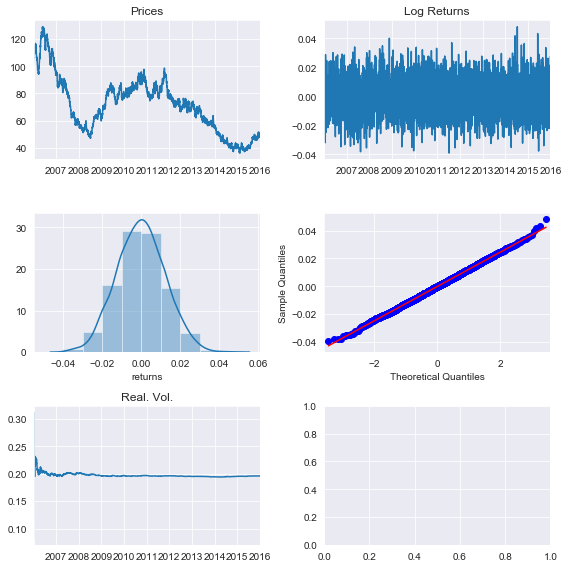

In [192]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8,8))


df['prices'].plot(title='Prices', ax=axes[0,0])
df['returns'].plot(title='Log Returns', ax=axes[0,1])

bins = np.arange(-0.05,0.05,0.01)
ax = sns.distplot(df['returns'], bins=bins, ax=axes[1,0])
sm.qqplot(df['returns'], line='s', ax=axes[1,1])

df['real_vol'].plot(title='Real. Vol.', ax=axes[2,0])

plt.tight_layout()

Realized volatility converges to instantaneous volatility.